# CS5785 Homework 2

[Yufan Zhang](https://yufanbruce.com/) (yz2894)

Tian Jin (tj299)


## Preparation


In [108]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

# NLTK
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

# Ignore any warnings
import warnings

warnings.filterwarnings("ignore")

In [109]:
# PATH variables
DATA_PATH = "./data/"
IMG_PATH = "./img/"
RESULT_PATH = "./result/"

if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [110]:
# Record trained models and their results
models = dict()


def infer_and_save_result(
    model_name, vectorizer, model, X_train, y_train, X_dev, y_dev
):
    print(model_name)
    X_train_vec = vectorizer.transform(X_train['text'])
    X_train_vec = pd.DataFrame(
        X_train_vec.toarray(), columns=vectorizer.get_feature_names_out()
    )
    X_dev_vec = vectorizer.transform(X_dev['text'])
    X_dev_vec = pd.DataFrame(
        X_dev_vec.toarray(), columns=vectorizer.get_feature_names_out()
    )

    # Infer the training set
    y_pred_train = model.predict(X_train_vec)
    # Calculate the F1 score
    f1_train = f1_score(y_train, y_pred_train, average="macro")
    print("F1 score on training set: {:.4f}".format(f1_train))

    # Infer the dev set
    y_pred_dev = model.predict(X_dev_vec)
    # Calculate the F1 score
    f1_dev = f1_score(y_dev, y_pred_dev, average="macro")
    print("F1 score on dev set: {:.4f}".format(f1_dev))

    # Save the result
    models[model_name] = {
        "vectorizer": vectorizer,
        "model": model,
        "f1_train": f1_train,
        "f1_dev": f1_dev,
    }

In [111]:
# Two helper functions to keep or drop features
def keep_features(df, features_to_keep):
    return df[features_to_keep]


def drop_features(df, features_to_drop):
    return df.drop(features_to_drop, axis=1)

## Data Loading

In [112]:
# Load the training and test data
def load_data_from_csv(filename):
    """
    Load the data to a Pandas dataframe from a file

    Args:
        filename: string containing the path to the dataset

    Return:
        a Pandas dataframe containing the loaded data
    """
    return pd.read_csv(os.path.join(DATA_PATH, filename), index_col=0)

# Load the train data
df = load_data_from_csv("train.csv")
print(f"Shape of the training data: {df.shape}")

X_test = load_data_from_csv("test.csv")
print(f"Shape of the test data: {X_test.shape}")

df

Shape of the training data: (7613, 4)
Shape of the test data: (3263, 3)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [113]:
df = keep_features(df, ["text", "target"])
X_test = keep_features(X_test, ["text"])

In [114]:
# How many training and test data points are there?
print("The number of data points:")
print(f"training data \t {len(df)}")
print(f"test data \t {len(X_test)}")
print()

# What percentage of the training tweets are of real disasters, and what percentage are not?
print("Percentage of training tweets are of real disasters:")
print(f"{df['target'].value_counts()[1]} / {len(df)} = {round(df['target'].value_counts()[1]/len(df)*100, 2)}%")
print("Percentage of training tweets are not of real disasters:")
print(f"{df['target'].value_counts()[0]} / {len(df)} = {round(df['target'].value_counts()[0]/len(df)*100, 2)}%")

The number of data points:
training data 	 7613
test data 	 3263

Percentage of training tweets are of real disasters:
3271 / 7613 = 42.97%
Percentage of training tweets are not of real disasters:
4342 / 7613 = 57.03%


### Split the training data

In [115]:
# Split the training data into training and validation sets w/o sklearn
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return (
        X.iloc[train_indices],
        X.iloc[test_indices],
        y.iloc[train_indices],
        y.iloc[test_indices],
    )
    
X = drop_features(df, ["target"])
y = keep_features(df, ["target"])

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3)

print(f"X_train: {X_train.shape} \t y_train: {y_train.shape}")
print(f"X_dev: {X_dev.shape} \t y_dev: {y_dev.shape}")

X_train: (5330, 1) 	 y_train: (5330, 1)
X_dev: (2283, 1) 	 y_dev: (2283, 1)


## Data Processing

In [116]:
# Handle hashtags: split the words in the hashtags and remove the hashtag symbol
# hashtags like #DataScience contain multiple words that are valuable when separated.
def handle_hashtags(df):
    def split_hashtag_into_words(text):
        # Split words in hashtag
        return " ".join(
            re.findall(r"[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)", text)
        )

    df["text"] = df["text"].apply(
        lambda x: re.sub(r"#(\S+)", lambda y: split_hashtag_into_words(y.group(1)), x)
    )
    return df


X_train = handle_hashtags(X_train)
X_dev = handle_hashtags(X_dev)

X_train

,text
id,
9674,I liked a @YouTube video http://t.co/itnKBxgWL...
1707,Ashes 2015: AustraliaÛªs collapse at Trent Br...
5789,GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...
7789,CNN: Tennessee movie theater shooting suspect ...
8257,Still rioting in a couple of hours left until ...
...,...
7470,@Eganator2000 There aren't many Obliteration s...
7691,just had a panic attack bc I don't have enough...
1242,Omron HEM-712C Automatic Blood Pressure Monito...


In [117]:
# Convert all the words to lowercase in the training set
def convert_to_lowercase(df):
    df["text"] = df["text"].str.lower()
    return df

X_train = convert_to_lowercase(X_train)
X_dev = convert_to_lowercase(X_dev)
X_train

,text
id,
9674,i liked a @youtube video http://t.co/itnkbxgwl...
1707,ashes 2015: australiaûªs collapse at trent br...
5789,great michigan technique camp\nb1g thanks to @...
7789,cnn: tennessee movie theater shooting suspect ...
8257,still rioting in a couple of hours left until ...
...,...
7470,@eganator2000 there aren't many obliteration s...
7691,just had a panic attack bc i don't have enough...
1242,omron hem-712c automatic blood pressure monito...


In [118]:
import nltk
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yufanzhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yufanzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yufanzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
# Strip @ and urls.
def strip_mentions_and_urls(df):
    def helper(text):
        # Remove @mentions
        text = re.sub(r"@\w+", "", text)
        # Remove URLs
        text = re.sub(r"http\S+", "", text)
        return text

    df["text"] = df["text"].apply(helper)
    return df


X_train = strip_mentions_and_urls(X_train)
X_dev = strip_mentions_and_urls(X_dev)

X_train

,text
id,
9674,i liked a video lexi belle for oklahoma torn...
1707,ashes 2015: australiaûªs collapse at trent br...
5789,great michigan technique camp\nb1g thanks to ...
7789,cnn: tennessee movie theater shooting suspect ...
8257,still rioting in a couple of hours left until ...
...,...
7470,there aren't many obliteration servers but i ...
7691,just had a panic attack bc i don't have enough...
1242,omron hem-712c automatic blood pressure monito...


In [120]:
# Lemmatize all the words
def lemmatize_words(df):
    lemmatizer = WordNetLemmatizer()
    df["text"] = df["text"].apply(
        lambda x: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(x)])
    )
    return df


X_train = lemmatize_words(X_train)
X_dev = lemmatize_words(X_dev)

X_train

,text
id,
9674,i liked a video lexi belle for oklahoma tornad...
1707,ash 2015 : australiaûªs collapse at trent bri...
5789,great michigan technique camp b1g thanks to . ...
7789,cnn : tennessee movie theater shooting suspect...
8257,still rioting in a couple of hour left until i...
...,...
7470,there are n't many obliteration server but i a...
7691,just had a panic attack bc i do n't have enoug...
1242,omron hem-712c automatic blood pressure monito...


In [121]:
# Strip punctuation
def strip_punctuation(df):
    df["text"] = df["text"].str.replace(r'[^\w\s]', "", regex=True)
    return df

X_train = strip_punctuation(X_train)
X_dev = strip_punctuation(X_dev)

X_train

,text
id,
9674,i liked a video lexi belle for oklahoma tornad...
1707,ash 2015 australiaûªs collapse at trent bridg...
5789,great michigan technique camp b1g thanks to g...
7789,cnn tennessee movie theater shooting suspect ...
8257,still rioting in a couple of hour left until i...
...,...
7470,there are nt many obliteration server but i al...
7691,just had a panic attack bc i do nt have enough...
1242,omron hem712c automatic blood pressure monitor...


In [122]:
# Remove latin characters and digits
def remove_latin_and_digits(df):
    df["text"] = df["text"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
    return df

X_train = remove_latin_and_digits(X_train)
X_dev = remove_latin_and_digits(X_dev)

X_train

,text
id,
9674,i liked a video lexi belle for oklahoma tornad...
1707,ash australias collapse at trent bridge amon...
5789,great michigan technique camp bg thanks to go...
7789,cnn tennessee movie theater shooting suspect ...
8257,still rioting in a couple of hour left until i...
...,...
7470,there are nt many obliteration server but i al...
7691,just had a panic attack bc i do nt have enough...
1242,omron hemc automatic blood pressure monitor st...


In [123]:
# Strip the stop words, e.g., “the”, “and”, “or”
def strip_stopwords(df):
    stop = stopwords.words("english")
    df["text"] = df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return df

X_train = strip_stopwords(X_train)  
X_dev = strip_stopwords(X_dev)

X_train

,text
id,
9674,liked video lexi belle oklahoma tornado victim
1707,ash australias collapse trent bridge among wor...
5789,great michigan technique camp bg thanks go blu...
7789,cnn tennessee movie theater shooting suspect k...
8257,still rioting couple hour left class
...,...
7470,nt many obliteration server always like play
7691,panic attack bc nt enough money drug alcohol w...
1242,omron hemc automatic blood pressure monitor st...


In [124]:
# Combine all the preprocessing steps into a single function
def data_preprocess(df):
    df = handle_hashtags(df)
    df = convert_to_lowercase(df)
    df = strip_mentions_and_urls(df)
    df = lemmatize_words(df)
    df = strip_punctuation(df)
    df = remove_latin_and_digits(df)
    df = strip_stopwords(df)
    return df

In [125]:
# Load the train data
df = load_data_from_csv("train.csv")

X = drop_features(df, ["target"])
y = keep_features(df, ["target"])

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3)

print(f"X_train: {X_train.shape} \t y_train: {y_train.shape}")
print(f"X_dev: {X_dev.shape} \t y_dev: {y_dev.shape}")

X_train = data_preprocess(X_train)
X_dev = data_preprocess(X_dev)

X_train: (5330, 3) 	 y_train: (5330, 1)
X_dev: (2283, 3) 	 y_dev: (2283, 1)


## Bag-of-Word Model

### Vectorize the data

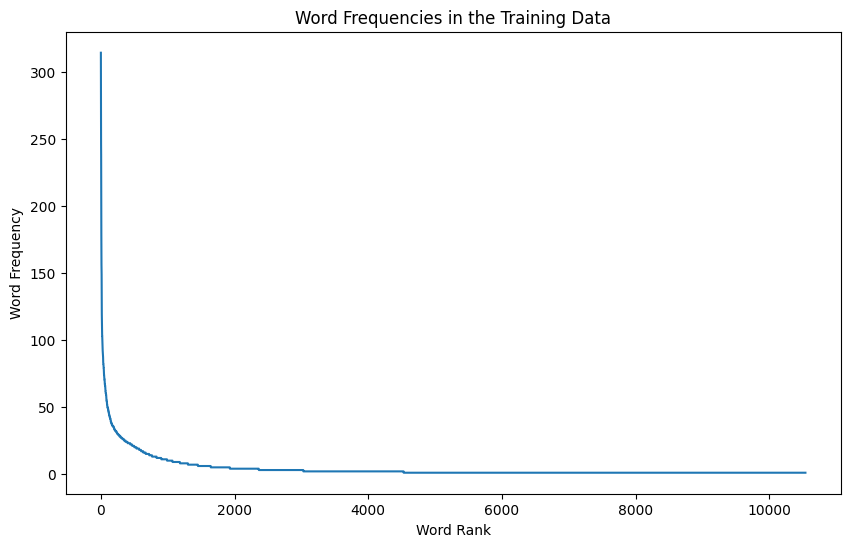

<Figure size 640x480 with 0 Axes>

In [126]:
# Create a CountVectorizer object without setting binary=True to get actual counts
vectorizer = CountVectorizer(binary=False)
X_train_counts = vectorizer.fit_transform(X_train['text'])

# Sum up the counts of each vocabulary word
word_freq = X_train_counts.sum(axis=0)
sorted_word_freq = np.sort(np.array(word_freq).reshape(-1))[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_word_freq)
plt.xlabel('Word Rank')
plt.ylabel('Word Frequency')
plt.title('Word Frequencies in the Training Data')
plt.show()
plt.savefig(os.path.join(IMG_PATH, "word_freq.png"))

In [127]:
# Remove all the words that appear less than 5 times in the sorted word frequency plot
print(f"Number of words {len(sorted_word_freq)}")
new_sorted_word_freq = sorted_word_freq[sorted_word_freq > 5]
print(f"Number of words that appear more than 5 times: {len(new_sorted_word_freq)}")

new_sorted_word_freq

Number of words 10539
Number of words that appear more than 5 times: 1643


array([314, 273, 255, ...,   6,   6,   6])

In [128]:
# Remove all the words that appear less than 5 times in the sorted word frequency plot
print(f"Number of words {len(sorted_word_freq)}")
new_sorted_word_freq = sorted_word_freq[sorted_word_freq > 2]
print(f"Number of words that appear more than 5 times: {len(new_sorted_word_freq)}")

new_sorted_word_freq

Number of words 10539
Number of words that appear more than 5 times: 3028


array([314, 273, 255, ...,   3,   3,   3])

In [129]:
# Remove all the words that appear less than 5 times in the sorted word frequency plot
print(f"Number of words {len(sorted_word_freq)}")
new_sorted_word_freq = sorted_word_freq[sorted_word_freq > 1]
print(f"Number of words that appear more than 5 times: {len(new_sorted_word_freq)}")

new_sorted_word_freq

Number of words 10539
Number of words that appear more than 5 times: 4528


array([314, 273, 255, ...,   2,   2,   2])

In [130]:
# Remove all the words that appear less than 5 times in the sorted word frequency plot
print(f"Number of words {len(sorted_word_freq)}")
new_sorted_word_freq = sorted_word_freq[sorted_word_freq > 0]
print(f"Number of words that appear more than 5 times: {len(new_sorted_word_freq)}")

new_sorted_word_freq

Number of words 10539
Number of words that appear more than 5 times: 10539


array([314, 273, 255, ...,   1,   1,   1])

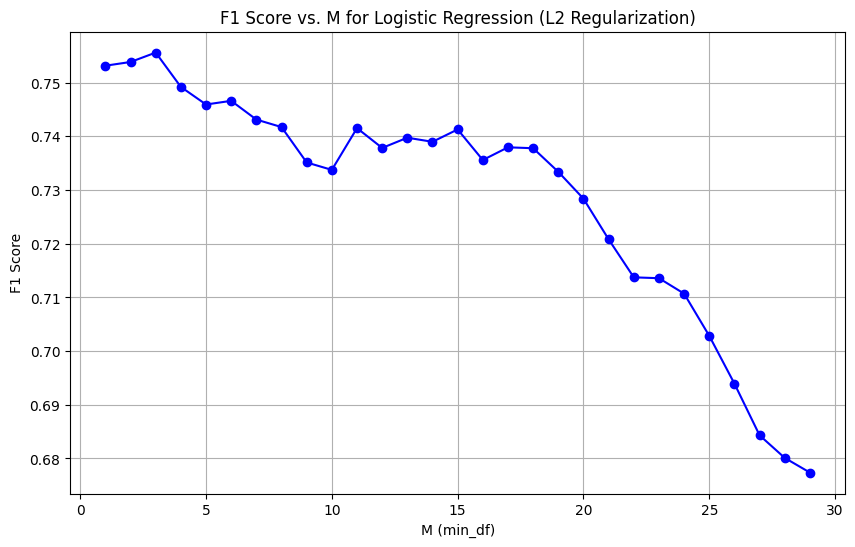

In [131]:
# Find the M with the highest F1 score

# Initialize empty lists to store values
M_values = []
F1_scores = []

# Find the M with the highest F1 score
for M in range(1, 30, 1):
    # Initialize the CountVectorizer with binary=True and min_df=M
    vectorizer = CountVectorizer(binary=True, min_df=M)

    # Transform the test data
    X_train_bow_matrix = vectorizer.fit_transform(X_train['text'])
    
    # Convert the binary BoW matrix to a DataFrame
    X_train_bow = pd.DataFrame(
        X_train_bow_matrix.toarray(), columns=vectorizer.get_feature_names_out()
    )
    
    # Initialize the model
    model = LogisticRegression(penalty="l2", max_iter=1000)

    # Train the model
    model.fit(X_train_bow, y_train)

    # Predict the labels of the validation set
    y_pred = model.predict(vectorizer.transform(X_dev['text']))

    # Calculate the F1 score of the predictions
    score = f1_score(y_dev, y_pred)

    # Append M and its corresponding F1 score to the lists
    M_values.append(M)
    F1_scores.append(score)
    
    
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(M_values, F1_scores, marker='o', linestyle='-', color='b')
plt.title("F1 Score vs. M for Logistic Regression (L2 Regularization)")
plt.xlabel("M (min_df)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.savefig(os.path.join(IMG_PATH, "f1_score_vs_m_bow.png"))
plt.show()


In [132]:
# Get the index of the M with the highest F1 score
best_idx = np.argmax(F1_scores)
print(f"Best value for M: {M_values[best_idx]}")

Best value for M: 3


In [133]:
# The threshold for the minimum number of documents a word should be present in to be kept
M = 3

# Use CountVectorizer to convert the text into a bag-of-words representation
# Initialize the CountVectorizer with binary=True and min_df=M
vectorizer = CountVectorizer(binary=True, min_df=M)

# Transform the test data
X_train_bow_matrix = vectorizer.fit_transform(X_train['text'])

# Convert the binary BoW matrix to a DataFrame
X_train_bow = pd.DataFrame(
    X_train_bow_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

X_dev_bow_matrix = vectorizer.transform(X_dev['text'])
X_dev_bow = pd.DataFrame(
    X_dev_bow_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

X_train_bow

,aa,ab,aba,abandoned,abbswinston,abc,ability,ablaze,able,absolutely,...,young,youth,youtube,youve,yr,yyc,yycstorm,zionist,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['aa', 'ab', 'aba', ..., 'zionist', 'zombie', 'zone'], dtype=object)

### Logistic Regression

In [135]:
# Train a logistic regression without regularization
# Initialize the model
model = LogisticRegression(penalty="none", max_iter=1000)

# Train the model
model.fit(X_train_bow, y_train)

infer_and_save_result(
    "Logistic Regression (Without Regularization) with BoW",
    vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (Without Regularization) with BoW
F1 score on training set: 0.9813
F1 score on dev set: 0.7084


In [136]:
# Train a logistic regression with L1 regularization
# Initialize the model
model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)

# Train the model
model.fit(X_train_bow, y_train)

infer_and_save_result(
    "Logistic Regression (L1 Regularization) with BoW",
    vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (L1 Regularization) with BoW
F1 score on training set: 0.8718
F1 score on dev set: 0.7878


In [137]:
# Get the L1 regularization logistic regression model
model_dict = models["Logistic Regression (L1 Regularization) with BoW"]
model = model_dict["model"]
fea_names = model_dict["vectorizer"].get_feature_names_out()

# Get the weight vector of the classifier
coefficients = model.coef_[0]

# Pair feature names with their coefficients
fea_coef = zip(fea_names, coefficients)

# Sort the features by their absolute coefficients in descending order
sorted_features = sorted(fea_coef, key=lambda x: abs(x[1]), reverse=True)

# Print the most important words/features
num_top_words = 10  # You can adjust this to show more or fewer top words
print(f"Top {num_top_words} words for predicting a real disaster:")
for feature, coef in sorted_features[:num_top_words]:
    print(f"{feature}: {coef}")

Top 10 words for predicting a real disaster:
hiroshima: 3.4720888850809217
spill: 3.390831851113706
typhoon: 3.2693228165872403
airport: 3.225919688141403
migrant: 3.1984165091845718
derailment: 3.183601300913764
wildfire: 3.1071986942451058
earthquake: 2.980615115721142
debris: 2.9161073242507816
outbreak: 2.88980437558876


In [138]:
# Train a logistic regression with L2 regularization
# Initialize the model
model = LogisticRegression(penalty="l2", max_iter=1000)

# Train the model
model.fit(X_train_bow, y_train)

infer_and_save_result(
    "Logistic Regression (L2 Regularization) with BoW",
    vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (L2 Regularization) with BoW
F1 score on training set: 0.9066
F1 score on dev set: 0.7955


### Bernoulli Naive Bayes

In [139]:
# Implement the Naive Bayes classifier with Laplace smoothing
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing parameter
        self.d = None  # Number of features
        self.K = None  # Unique class labels
        self.psis = None  # Parameters of the Bernoulli distributions
        self.phis = None  # Class priors

    def fit(self, X, y):
        self.K = np.unique(y).shape[0]
        n = X.shape[0]  # Number of data points
        self.d = X.shape[1]
        self.psis = np.zeros([self.K, self.d])
        self.phis = np.zeros([self.K])

        # Update the parameters
        for k in range(self.K):
            X_k = X[np.array(y == k)[:, 0]]
            self.psis[k] = (X_k.sum(axis=0) + self.alpha) / float(
                X_k.shape[0] + 2 * self.alpha
            )
            self.phis[k] = X_k.shape[0] / float(n)

    def predict(self, x):
        # adjust shapes
        n, d = x.shape
        x = np.reshape(x, (1, n, self.d))
        psis = np.reshape(self.psis, (self.K, 1, d))

        # clip probabilities to avoid log(0)
        psis = psis.clip(1e-14, 1 - 1e-14)

        # compute log-probabilities
        logpy = np.log(self.phis).reshape([self.K, 1])
        logpxy = x * np.log(psis) + (1 - x) * np.log(1 - psis)
        logpyx = logpxy.sum(axis=2) + logpy

        return logpyx.argmax(axis=0).flatten()

In [140]:
# Make predictions on the dev set
bayes = BernoulliNaiveBayes()
bayes.fit(X_train_bow, y_train)

infer_and_save_result(
    "Bernoulli Naive Bayes with BoW",
    vectorizer,
    bayes,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Bernoulli Naive Bayes with BoW
F1 score on training set: 0.8481
F1 score on dev set: 0.7963


## N-Gram Model

In [141]:
# Train an N-gram model with sklearn with N=2
# Initialize the CountVectorizer
ngram_vectorizer = CountVectorizer(binary=True, min_df=11, ngram_range=(2, 2))

# Transform the training data
X_train_ng = ngram_vectorizer.fit_transform(X_train['text'])
X_train_ng = pd.DataFrame(
    X_train_ng.toarray(), columns=ngram_vectorizer.get_feature_names_out()
)

# Transform the validation data
X_dev_ng = ngram_vectorizer.transform(X_dev['text'])
X_dev_ng = pd.DataFrame(
    X_dev_ng.toarray(), columns=ngram_vectorizer.get_feature_names_out()
)

X_train_ng

,abc news,added video,affected fatal,ai nt,air ambulance,airport get,ambulance helicopter,appears blast,army trench,atomic bomb,...,water rescuer,wave black,wild fire,wildfire abc,wind neighbour,wo nt,work light,wreckage conclusively,year ago,yr old
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logistic Regression

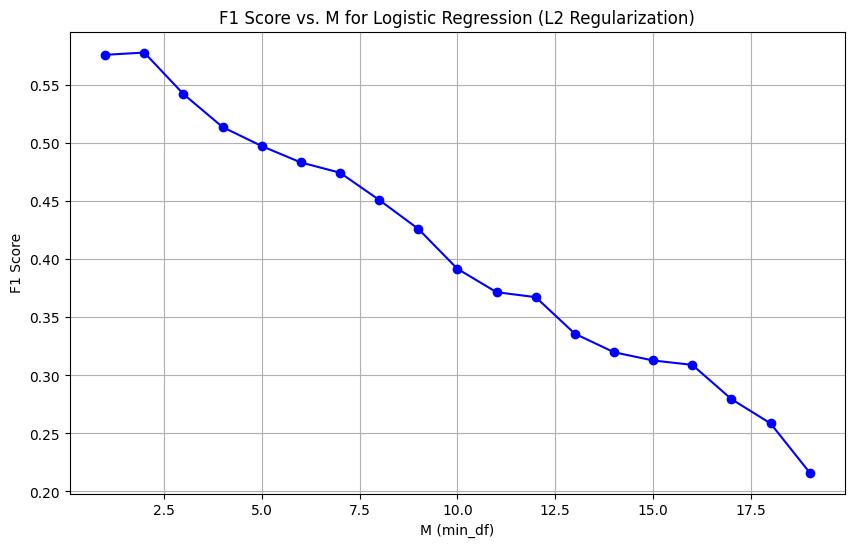

In [142]:
# Find the min_df with the highest F1 score
# Initialize empty lists to store values
M_values = []
F1_scores = []

# Find the M with the highest F1 score
for M in range(1, 20, 1):
    # Initialize the CountVectorizer with binary=True and min_df=M
    vectorizer = CountVectorizer(binary=True, min_df=M, ngram_range=(2, 2))

    # Transform the test data
    X_train_bow_matrix = vectorizer.fit_transform(X_train['text'])
    
    # Convert the binary BoW matrix to a DataFrame
    X_train_bow = pd.DataFrame(
        X_train_bow_matrix.toarray(), columns=vectorizer.get_feature_names_out()
    )
    
    # Initialize the model
    model = LogisticRegression(penalty="l2", max_iter=1000)

    # Train the model
    model.fit(X_train_bow, y_train)

    # Predict the labels of the validation set
    y_pred = model.predict(vectorizer.transform(X_dev['text']))

    # Calculate the F1 score of the predictions
    score = f1_score(y_dev, y_pred)

    # Append M and its corresponding F1 score to the lists
    M_values.append(M)
    F1_scores.append(score)
    

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(M_values, F1_scores, marker='o', linestyle='-', color='b')
plt.title("F1 Score vs. M for Logistic Regression (L2 Regularization)")
plt.xlabel("M (min_df)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.savefig(os.path.join(IMG_PATH, "f1_score_vs_m_ngram.png"))

In [143]:
# Get the index of the M with the highest F1 score
best_idx = np.argmax(F1_scores)
print(f"Best value for M: {M_values[best_idx]}")

Best value for M: 2


In [144]:
M = 2

# Train an N-gram model with sklearn with N=2
# Initialize the CountVectorizer
ngram_vectorizer = CountVectorizer(binary=True, min_df=M, ngram_range=(2, 2))

# Transform the training data
X_train_ng = ngram_vectorizer.fit_transform(X_train['text'])
X_train_ng = pd.DataFrame(
    X_train_ng.toarray(), columns=ngram_vectorizer.get_feature_names_out()
)

# Transform the validation data
X_dev_ng = ngram_vectorizer.transform(X_dev['text'])
X_dev_ng = pd.DataFrame(
    X_dev_ng.toarray(), columns=ngram_vectorizer.get_feature_names_out()
)

In [145]:
# Train a logistic regression without regularization
# Initialize the model
model = LogisticRegression(penalty="none", max_iter=1000)

# Train the model
model.fit(X_train_ng, y_train)

infer_and_save_result(
    "Logistic Regression (Without Regularization) with N-gram",
    ngram_vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (Without Regularization) with N-gram
F1 score on training set: 0.8281
F1 score on dev set: 0.6951


In [146]:
# Train a logistic regression with L1 regularization
# Initialize the model
model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)

# Train the model
model.fit(X_train_ng, y_train)

infer_and_save_result(
    "Logistic Regression (L1 Regularization) with N-gram",
    ngram_vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (L1 Regularization) with N-gram
F1 score on training set: 0.7395
F1 score on dev set: 0.6671


In [147]:
# Train a logistic regression with L2 regularization
# Initialize the model
model = LogisticRegression(penalty="l2", max_iter=1000)

# Train the model
model.fit(X_train_ng, y_train)

infer_and_save_result(
    "Logistic Regression (L2 Regularization) with N-grams",
    ngram_vectorizer,
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Logistic Regression (L2 Regularization) with N-grams
F1 score on training set: 0.7913
F1 score on dev set: 0.6908


### Bernoulli Naive Bayes

In [148]:
# Make predictions on the dev set
bayes = BernoulliNaiveBayes()
bayes.fit(X_train_ng, y_train)

infer_and_save_result(
    "Bernoulli Naive Bayes with N-grams",
    ngram_vectorizer,
    bayes,
    X_train,
    y_train,
    X_dev,
    y_dev,
)

Bernoulli Naive Bayes with N-grams
F1 score on training set: 0.7216
F1 score on dev set: 0.6430


## Model Performance on Test Set

In [149]:
models

{'Logistic Regression (Without Regularization) with BoW': {'vectorizer': CountVectorizer(binary=True, min_df=3),
  'model': LogisticRegression(max_iter=1000, penalty='none'),
  'f1_train': 0.9812600518148769,
  'f1_dev': 0.7083655284147558},
 'Logistic Regression (L1 Regularization) with BoW': {'vectorizer': CountVectorizer(binary=True, min_df=3),
  'model': LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'),
  'f1_train': 0.8717664386327061,
  'f1_dev': 0.7878212164822787},
 'Logistic Regression (L2 Regularization) with BoW': {'vectorizer': CountVectorizer(binary=True, min_df=3),
  'model': LogisticRegression(max_iter=1000),
  'f1_train': 0.9065625254137448,
  'f1_dev': 0.7955253090208536},
 'Bernoulli Naive Bayes with BoW': {'vectorizer': CountVectorizer(binary=True, min_df=3),
  'model': <__main__.BernoulliNaiveBayes at 0x299bd1a90>,
  'f1_train': 0.8480544289660847,
  'f1_dev': 0.7962633828231602},
 'Logistic Regression (Without Regularization) with N-gram': {'vect

In [150]:
# Sort the models by their F1 score on the dev set
sorted_models = sorted(models.items(), key=lambda x: x[1]["f1_dev"], reverse=True)

# Print the model name and its corresponding F1 score on the dev set
for model_name, model_dict in sorted_models:
    print(f"{model_name}: {model_dict['f1_dev']}")

Bernoulli Naive Bayes with BoW: 0.7962633828231602
Logistic Regression (L2 Regularization) with BoW: 0.7955253090208536
Logistic Regression (L1 Regularization) with BoW: 0.7878212164822787
Logistic Regression (Without Regularization) with BoW: 0.7083655284147558
Logistic Regression (Without Regularization) with N-gram: 0.6950772099580469
Logistic Regression (L2 Regularization) with N-grams: 0.6907626931078749
Logistic Regression (L1 Regularization) with N-gram: 0.6670723268892627
Bernoulli Naive Bayes with N-grams: 0.6430426493539867


In [151]:
# Infer the test set on the best model
best_model = sorted_models[0][1]["model"]
print(f"Best model: {sorted_models[0][0]}")
best_model_vectorizer = sorted_models[0][1]["vectorizer"]

Best model: Bernoulli Naive Bayes with BoW


In [152]:
# Retrain the best model on the entire training set
# Data preprocessing
df_train = data_preprocess(df)
df_target = keep_features(df, ["target"])
df_train = keep_features(df_train, ["text"])

In [153]:
# The threshold for the minimum number of documents a word should be present in to be kept
M = 3

# Use CountVectorizer to convert the text into a bag-of-words representation
# Initialize the CountVectorizer with binary=True and min_df=M
best_model_vectorizer = CountVectorizer(binary=True, min_df=M)

# Transform the test data
df_train_bow_matrix = best_model_vectorizer.fit_transform(df_train['text'])

# Convert the binary BoW matrix to a DataFrame
df_train_bow = pd.DataFrame(
    df_train_bow_matrix.toarray(), columns=best_model_vectorizer.get_feature_names_out()
)

df_train_bow

,aa,ab,aba,abandon,abandoned,abbswinston,abc,abe,ability,ablaze,...,yugvani,yyc,yycstorm,zayn,zero,zionist,zipped,zombie,zone,zouma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
# Retrain the best model on the entire training set: Bernoulli Naive Bayes with BoW
# Initialize the model
best_model = BernoulliNaiveBayes()
best_model.fit(df_train_bow, df_target)

In [159]:
# Transform the test data
X_test = data_preprocess(X_test)

# Vectorize the test data
X_test_vec = best_model_vectorizer.transform(X_test['text'])

# Convert the binary BoW matrix to a DataFrame
X_test_vec = pd.DataFrame(
    X_test_vec.toarray(), columns=best_model_vectorizer.get_feature_names_out()
)

# Infer the test set
y_pred_test = best_model.predict(X_test_vec)

# Save the predictions to a CSV file name `submission_{today's datetime}.csv` with the following format: id, target
submission = pd.DataFrame(
    {"id": X_test.index, "target": y_pred_test}
)

# Save the submission file
submission.to_csv(
    os.path.join(RESULT_PATH, f"submission_{datetime.datetime.now()}.csv"), index=False
)